In [16]:
from helpers import *
import numpy as np
import pandas as pd
from implementations import *
import matplotlib.pyplot as plt


In [17]:
data_path = '../data/dataset_to_release'
x_train_preclean, x_test_preclean, y_train, train_ids, test_ids = load_csv_data(data_path)

# Getting an idea of the data

In [18]:
print("X train", x_train_preclean.shape)
print("X test", x_test_preclean.shape)

X train (328135, 321)
X test (109379, 321)


Text(0, 0.5, '# of columns')

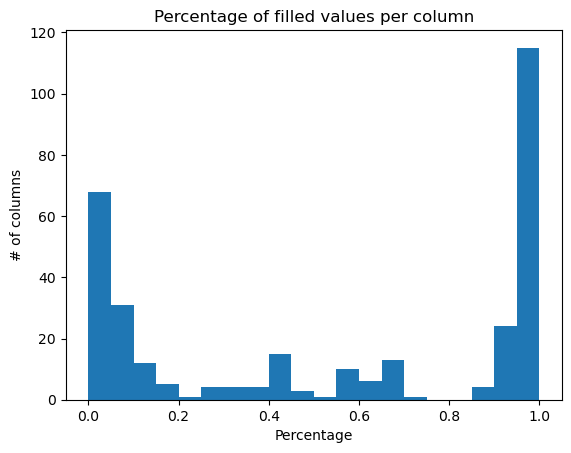

In [19]:
## Find how many values are completely empty in column
def percentageFilled(data):
    return 1 - np.isnan(data).sum() / len(data)

percentage_filled = np.apply_along_axis(percentageFilled, 0, x_train_preclean)

plt.hist(percentage_filled, bins=20)
plt.title("Percentage of filled values per column")
plt.xlabel("Percentage")
plt.ylabel("# of columns")

# Data Cleaning

In [20]:
## Process data 
## 1. drop the columns with more than 80% missing values
def threshold_col_filter(data, threshold):
    """ 
    filter out data where the column has less than threshold percentage of data
    returns: 
        indicies of columns to keep
    """
    percentage_filled = np.apply_along_axis(percentageFilled, 0, data)
    # keep_indicies = np.argwhere(percentage_filled > threshold).flatten()
    return percentage_filled > threshold


def non_constant_filter(data):
    """
    filter out where the values in the column are all the same
    """
    return np.logical_not(np.logical_or(np.isnan(np.nanstd(data, 0)), np.nanstd(data, 0) == 0))

# TODO uncorrelation?
    

# TODO correlation w
## SEE LATER, done at a later stage, after these two steps  


keep_indicies = np.argwhere(np.logical_and(
    threshold_col_filter(x_train_preclean, 0.2), 
    non_constant_filter(x_train_preclean)
    )
).flatten()


In [21]:
def filter_columns_by_indicies(data, keep_indicies):
    """
    used to process test data 
    only keep the columns that are in the indicies 
    """
    return data[:, keep_indicies]


x_train = filter_columns_by_indicies(x_train_preclean, keep_indicies)
print("X train", x_train.shape)

x_test = filter_columns_by_indicies(x_test_preclean, keep_indicies)
print("X test", x_test.shape)

X train (328135, 201)
X test (109379, 201)


In [22]:
def is_categorical_feature(xn, threshold=0.05):
    return len(set(xn)) / len(xn) < threshold

def standardize(x):
    """Standardize the original data set."""
    return np.nan_to_num((x - np.nanmean(x, axis=0)) / np.nanstd(x, axis=0))

def one_hot_encode(xn):
    pass
     # TODO

# ind = np.apply_along_axis(is_categorical_feature, 0, x_train)

In [23]:
## 2. Replace the missing values with the mean of the column, add columns 
def standardize(x):
    """Standardize the original data set."""
    return np.nan_to_num((x - np.nanmean(x, axis=0)) / np.nanstd(x, axis=0))


def process_data(x):
    # col_means = np.nanmean(x, axis=0)
    # inds = np.where(np.isnan(x))
    # x[inds] = np.take(col_means, inds[1])  # replace columns with values NaN with the mean of that column
    # x = (x - np.mean(x)) / np.std(x)  # standarize the data 
    ## ?? I feel like standardizing by column shouldn't be done like above 
    x = standardize(x)
    x = np.c_[np.ones(len(x)), x]  # add the column of ones
    return x


x_train_std = process_data(x_train)
x_test_std = process_data(x_test)
print("x_train_std shape", x_train_std.shape)

# x_train_2 = process_data(x_train)
# x_test_2 = process_data(x_test_2)

x_train_std shape (328135, 202)


### correlation 

In [24]:
# Yiyuan's test code -- not sure how is this correlation numpy function working
# temp = np.array([[1, 2, 7], [19, 58, 37], [-2, 6, 14]])
# tempy = np.transpose(np.array([0, 3, -10]))
# print(temp)
# print("y", tempy)

# print("correlation is \n", np.corrcoef(temp, tempy, rowvar=False))

/Users/gladys/opt/anaconda3/envs/adaexam/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/gladys/opt/anaconda3/envs/adaexam/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(array([60., 44., 24., 15., 17.,  8.,  6.,  5.,  4.,  4.,  2.,  0.,  0.,
         2.,  2.,  1.,  4.,  1.,  1.,  1.]),
 array([0.00024561, 0.0124468 , 0.02464799, 0.03684918, 0.04905037,
        0.06125156, 0.07345275, 0.08565394, 0.09785513, 0.11005632,
        0.12225751, 0.13445871, 0.1466599 , 0.15886109, 0.17106228,
        0.18326347, 0.19546466, 0.20766585, 0.21986704, 0.23206823,
        0.24426942]),
 <BarContainer object of 20 artists>)

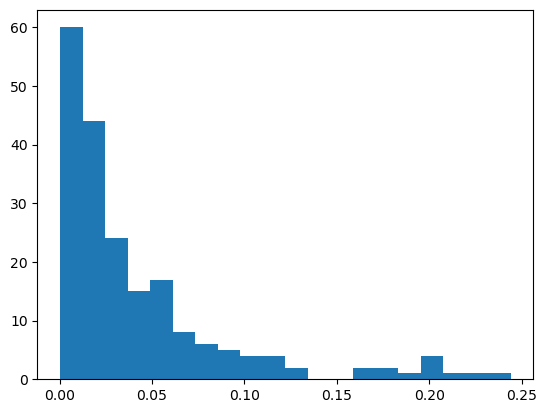

In [25]:
def feature_correlation(x_train, y_train):
    return np.abs(np.corrcoef(x_train, y_train, rowvar=False))

cr  =  feature_correlation(x_train_std, y_train)[-1, :-1]
plt.hist(cr, bins=20)

In [44]:
## Screen out features based on correlation
good_corre_indicies = np.argwhere(cr > 0.05).flatten()
print("good_corre_indicies", good_corre_indicies)
x_train_corre = x_train_std[:, good_corre_indicies]

good_corre_indicies [  8   9  12  14  20  21  27  28  29  30  31  32  33  35  36  37  38  40
  41  42  44  48  49  50  52  55  56  59  60  61  62  66  83  86  89  92
 100 107 111 112 113 114 115 119 127 128 129 130 133 134 135 137 138 139
 170 194 196]


# Logistic regression *without* regularization

In [45]:
initial_w = np.zeros(x_train_corre.shape[1], dtype=np.float128)
max_iters = 100
gamma = 0.5

In [46]:
## Here the logistic regression is from implementations.py
## 
w, loss = logistic_regression(y_train, x_train_corre, initial_w, max_iters, gamma)
print("loss is ", loss)


loss is  0.67002244908079179304


### Trying to predict x_test

In [47]:
def prediction_labels(weights, data):  ## isn't this for linear regression only ? Don't we need the sigmoid?
    """Generates class predictions given weights, and a test data matrix."""
    y_pred = sigmoid(np.dot(data, weights))
    y_pred[np.where(y_pred >= 0.5)] = 1
    y_pred[np.where(y_pred < 0.5)] = 0
    return y_pred

y_pred = prediction_labels(w, x_train_corre)
temp = y_pred[y_pred != 0]


In [48]:
def accuracy(y_pred, y_train):
    return (y_pred == y_train).sum() / len(y_train)
def precision(y_pred, y_train):
    TP = np.sum((y_train==1) & (y_pred==1))
    FP = np.sum((y_train==0) & (y_pred==1))
    return TP/(TP+FP)
def recall(y_pred, y_train):
    recall = np.sum((y_train==1) & (y_pred==1)) / np.sum(y_train==1)
    return recall
def f_score (y_pred, y_train):
    return 2*precision(y_pred, y_train)*recall(y_pred, y_train) / (precision(y_pred, y_train) + recall(y_pred, y_train))

print("accuracy", accuracy(y_pred, y_train))
print("precision", precision(y_pred, y_train))
print("recall", recall(y_pred, y_train))
print("f_score", f_score(y_pred, y_train))

accuracy 0.6277233455742302
precision 0.17924463353849118
recall 0.8985677308024159
f_score 0.2988710260633993


## Generate trained data 

In [49]:
##
y_pred = prediction_labels(w, x_test_std[:, good_corre_indicies])
y_pred[y_pred == 0] = -1

In [51]:
create_csv_submission(test_ids, y_pred, 'submission.csv')

### Logistic regression with regularization